In [1]:
import os
import time
import sys
sys.path.append("../")
from data_utils.load_data import load_dataset
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torch.nn as nn



TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_dataset()


Length of Text Vocabulary: 251639
Vector size of Text Vocabulary:  torch.Size([251639, 300])
Label Length: 2


In [2]:
# RCNN模型


class RCNN(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
		super(RCNN, self).__init__()
		
		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embedding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		"""
		
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
		self.dropout = 0.8
		self.lstm = nn.LSTM(embedding_length, hidden_size, dropout=self.dropout, bidirectional=True)
		self.W2 = nn.Linear(2*hidden_size+embedding_length, hidden_size)
		self.label = nn.Linear(hidden_size, output_size)
		
	def forward(self, input_sentence, batch_size=None):
	
		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
		final_output.shape = (batch_size, output_size)
		
		"""
		
		"""
		
		The idea of the paper "Recurrent Convolutional Neural Networks for Text Classification" is that we pass the embedding vector
		of the text sequences through a bidirectional LSTM and then for each sequence, our final embedding vector is the concatenation of 
		its own GloVe embedding and the left and right contextual embedding which in bidirectional LSTM is same as the corresponding hidden
		state. This final embedding is passed through a linear layer which maps this long concatenated encoding vector back to the hidden_size
		vector. After this step, we use a max pooling layer across all sequences of texts. This converts any varying length text into a fixed
		dimension tensor of size (batch_size, hidden_size) and finally we map this to the output layer.

		"""
		input = self.word_embeddings(input_sentence) # embedded input of shape = (batch_size, num_sequences, embedding_length)
		input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)
		if batch_size is None:
			h_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda()) # Initial hidden state of the LSTM
			c_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda()) # Initial cell state of the LSTM
		else:
			h_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())

		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
		
		final_encoding = torch.cat((output, input), 2).permute(1, 0, 2)
		y = self.W2(final_encoding) # y.size() = (batch_size, num_sequences, hidden_size)
		y = y.permute(0, 2, 1) # y.size() = (batch_size, hidden_size, num_sequences)
		y = F.max_pool1d(y, y.size()[2]) # y.size() = (batch_size, hidden_size, 1)
		y = y.squeeze(2)
		logits = self.label(y)
		
		return logits


In [3]:

learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 256
embedding_length = 300

model = RCNN(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
loss_fn = F.cross_entropy

/data3/wangzhiyong/miniconda3/envs/cv-homework/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [4]:

def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
    
def train_model(model, train_iter, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] != 32):# One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction = model(text)
        loss = loss_fn(prediction, target)
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        
        # if steps % 100 == 0:
        #     print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] != 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            loss = loss_fn(prediction, target)
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)
	

In [5]:
losses = []
accuracies = []
eval_accuracies = []
test_accuracies = []
temp_Acc = 0
total_epoch = 10
file_path = './models/best_RCNN.pth'
for epoch in range(total_epoch):
    train_loss, train_acc = train_model(model, train_iter, epoch)
    val_loss, val_acc = eval_model(model, valid_iter)
    test_loss, test_acc = eval_model(model, test_iter)
    losses.append(train_loss)
    accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    eval_accuracies.append(val_acc)
    # print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%,  Val. Acc: {val_acc:.2f}%')
    if test_acc>temp_Acc:
        temp_Acc = test_acc
        
        if os.path.exists(file_path):
            # 删除文件
            os.remove(file_path)
        torch.save(model.state_dict(),file_path )
import matplotlib.pyplot as plt




# 绘制损失-轮次图表
epochs = range(1, total_epoch+1)


/data3/wangzhiyong/miniconda3/envs/cv-homework/lib/python3.8/site-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths
/data3/wangzhiyong/miniconda3/envs/cv-homework/lib/python3.8/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


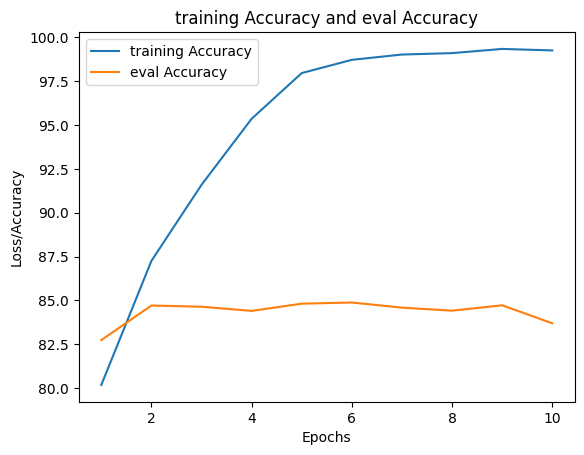

In [6]:
plt.plot(epochs, accuracies, label='training Accuracy')
plt.plot(epochs, eval_accuracies, label='eval Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('training Accuracy and eval Accuracy')
plt.legend()
plt.show()



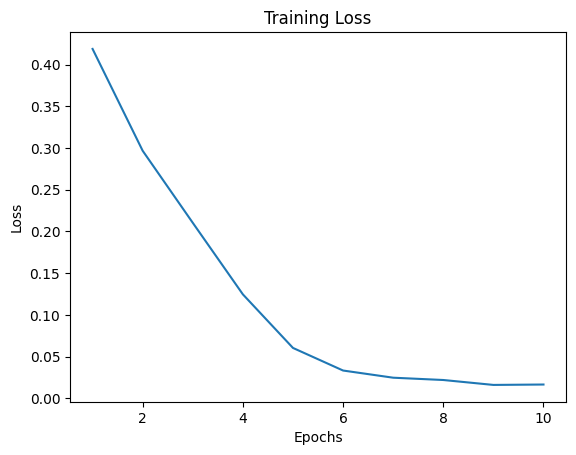

In [7]:
plt.plot(epochs, losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()



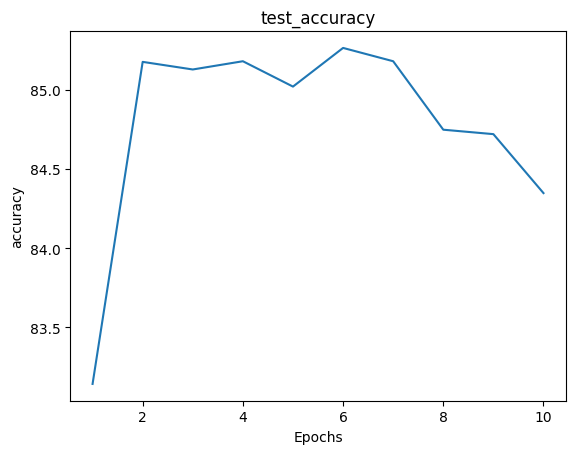

epoch:1,test accuracy:83.14418158567774
epoch:2,test accuracy:85.17423273657289
epoch:3,test accuracy:85.12627877237851
epoch:4,test accuracy:85.17822890025576
epoch:5,test accuracy:85.01838235294117
epoch:6,test accuracy:85.2621483375959
epoch:7,test accuracy:85.17822890025576
epoch:8,test accuracy:84.74664322250639
epoch:9,test accuracy:84.71867007672634
epoch:10,test accuracy:84.34702685421995


In [8]:
plt.plot(epochs, test_accuracies)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('test_accuracy')
plt.show()
for e in epochs:
    print("epoch:{},test accuracy:{}".format(e,test_accuracies[e-1]))

In [9]:
testmodel = RCNN(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)

testmodel.load_state_dict(torch.load('models/best_RCNN.pth'))
test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
test_sen1 = TEXT.preprocess(test_sen1)
test_sen1 = [[TEXT.vocab.stoi[x] for x in test_sen1]]
test_sen = np.asarray(test_sen1)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen)
test_tensor = test_tensor.cuda()
model.eval()
output = model(test_tensor, 1)
out = F.softmax(output, 1)
if (torch.argmax(out[0]) == 1):
    print ("Sentiment: Positive")
else:
    print ("Sentiment: Negative")

/data3/wangzhiyong/miniconda3/envs/cv-homework/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Sentiment: Positive
